<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [586]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12})

In [587]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'D:\!Work/DATA/Coursera_Yandex/6_course/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [588]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as file :
        try :
            while True:
                site_dict = pickle.load(file)
        except EOFError :
            pass
            # print('Sites dictionary not loaded')

    files = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    n_users = len(files)

    sites_arr = np.zeros((int(np.ceil(n_users*20000/window_size)), session_length*2 - 1 + 5), dtype=int)

    i = 0
    for f in tqdm_notebook(range(n_users), desc='files_loaded : '):
        data = pd.read_csv(files[f])
        user_id = int(os.path.basename(files[f])[4:8])

        n_sites = data.shape[0]
        n_sess = n_sites // window_size + (n_sites % window_size > 0)
        n_samples = (n_sess-1) * window_size + session_length
        
        timestamp = pd.to_datetime(data.timestamp)

        np_arr = np.array([site_dict[key][0] for key in data.site.values] + (n_samples > n_sites) * \
                          (n_samples - n_sites) * [0])
        np_arr_diff = np.array(list(timestamp.diff(1).dt.seconds) + (n_samples > n_sites) * \
                          (n_samples - n_sites) * [0]).astype(int)
        
        indexer = np.arange(session_length)[None, :] + window_size * np.arange(n_sess)[:, None]

                
        sites_arr[i:i+n_sess, :session_length] = np_arr[indexer]
        sites_arr[i:i+n_sess, session_length:2*session_length-1] = np_arr_diff[indexer[:, 1:]]
        
        sites_arr[i:i+n_sess, -5] = sites_arr[i:i+n_sess, session_length:2*session_length-1].sum(axis=1) # session_timespan
        sites_arr[i:i+n_sess, -4] = np.array([len(set(row)) for row in sites_arr[i:i+n_sess, :session_length]]) # unique sites
        if sites_arr[i+n_sess-1, session_length-1] == 0 :
            sites_arr[i+n_sess-1, -4] -= 1
        sites_arr[i:i+n_sess, -3] = timestamp[::window_size].dt.hour.values #start hour
        sites_arr[i:i+n_sess, -2] = timestamp[::window_size].dt.weekday.values #day of week
        sites_arr[i:i+n_sess, -1] = user_id

        i += n_sess

    X_train = sites_arr[:i, :]
    
    return pd.DataFrame(data=X_train, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [589]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [590]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [591]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                               site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=10)


Wall time: 463 ms


In [592]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [593]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                                                site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'),
                                                feature_names=feature_names, session_length=10)


Wall time: 4.21 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [594]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [595]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [596]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [597]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [598]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [599]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [600]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [601]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

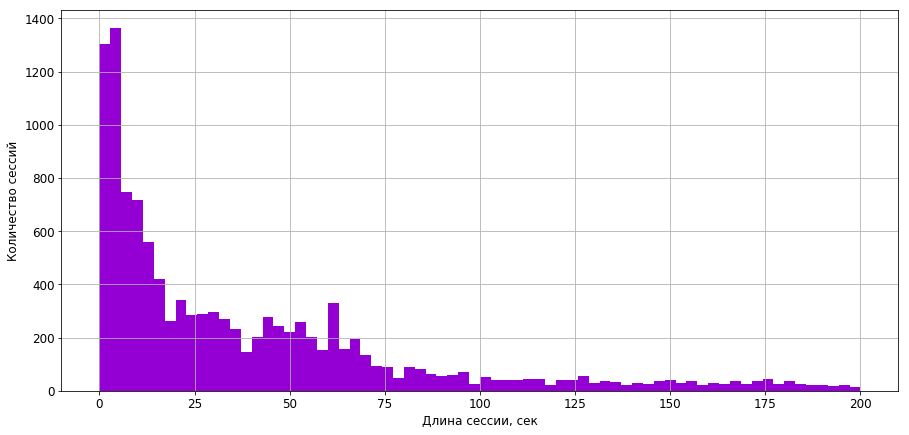

In [602]:
train_data_10users['session_timespan'][train_data_10users['session_timespan'].le(200)] \
.hist(bins=70, figsize=(15,7), color='darkviolet')

plt.xlabel('Длина сессии, сек')
plt.ylabel('Количество сессий')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

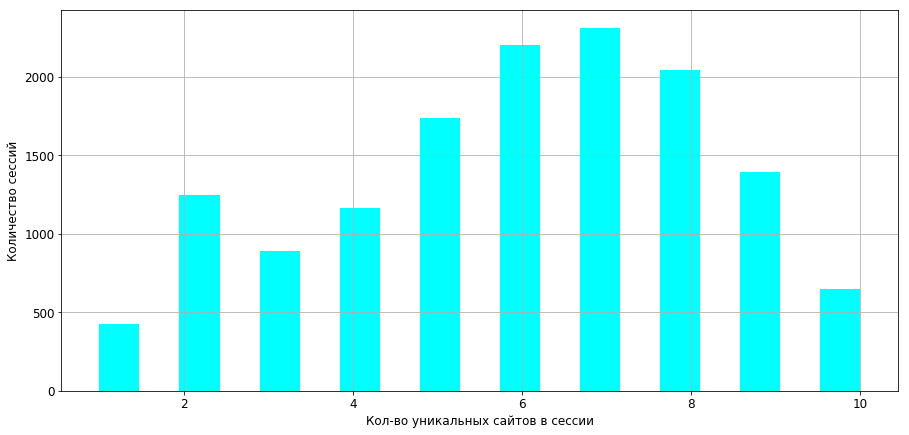

In [603]:
train_data_10users['#unique_sites'].hist(bins=19, figsize=(15,7), color='aqua')
plt.xlabel('Кол-во уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

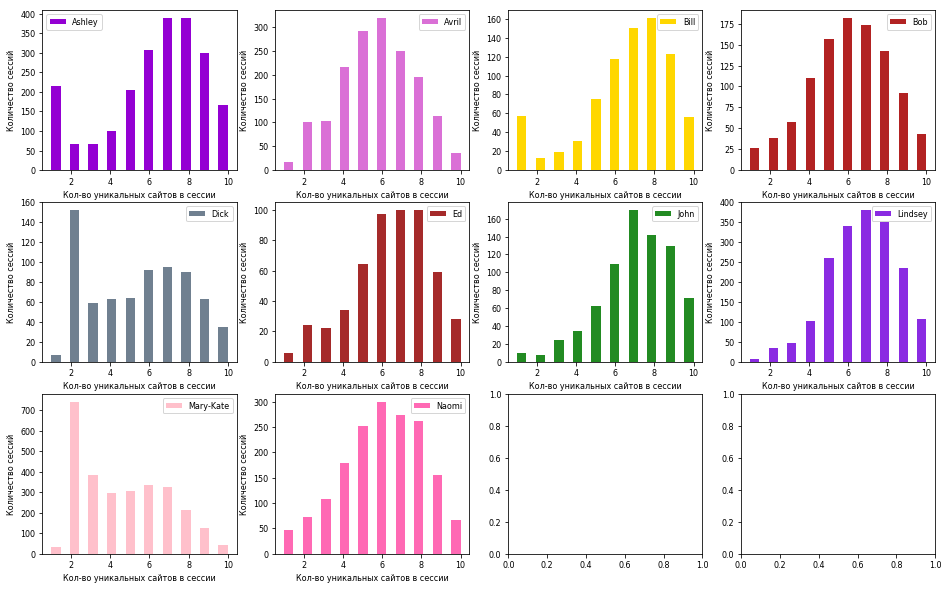

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx//ncols, idx%ncols].hist(sub_df['#unique_sites'], bins=19, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlabel('Кол-во уникальных сайтов в сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

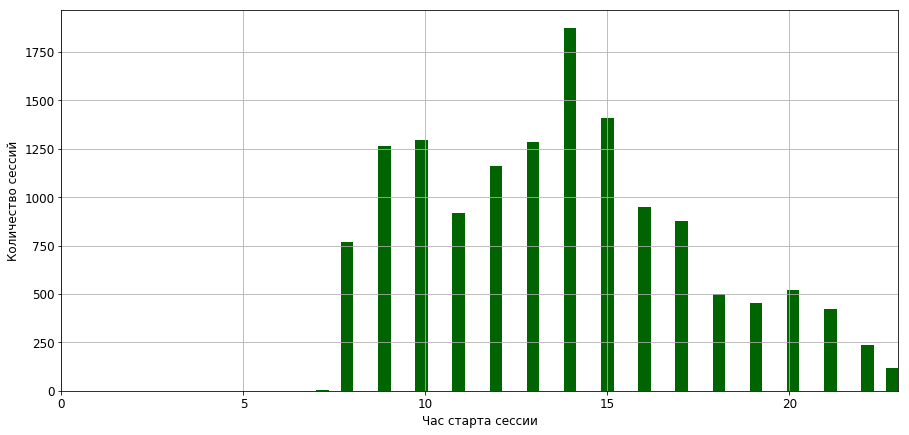

In [ ]:
plt.rcParams.update({'font.size': 12})

train_data_10users['start_hour'].hist(bins=47, figsize=(15,7), color='darkgreen')

plt.xlim([0,23])
plt.xlabel('Час старта сессии')
plt.ylabel('Количество сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

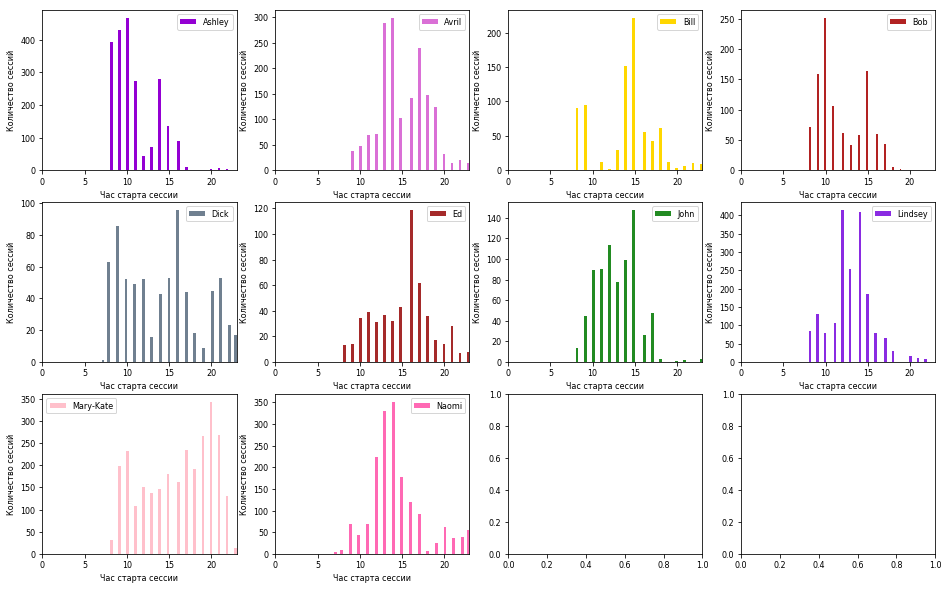

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx//ncols, idx%ncols].hist(sub_df['start_hour'], bins=47, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlim([0,23])
    axes[idx//ncols, idx%ncols].set_xlabel('Час старта сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

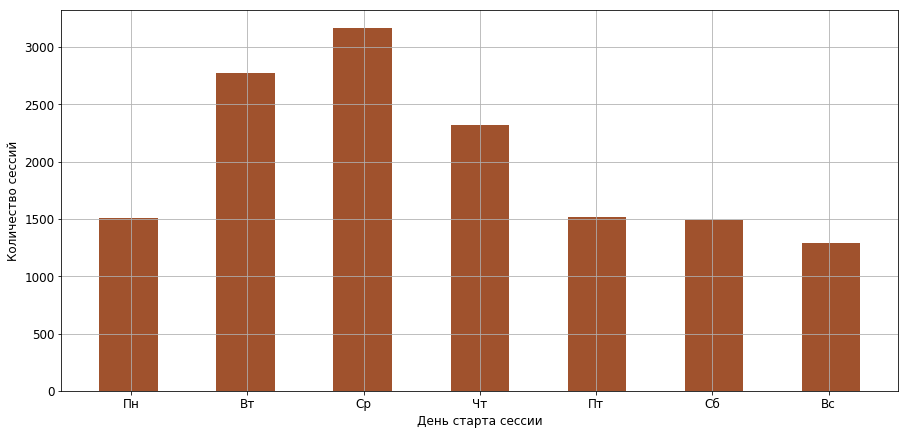

In [ ]:
plt.rcParams.update({'font.size': 12})

train_data_10users['day_of_week'].hist(bins=13, figsize=(15,7), color='sienna')

plt.xlabel('День старта сессии')
plt.ylabel('Количество сессий')
plt.xticks(np.linspace(0.25,5.75,7),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

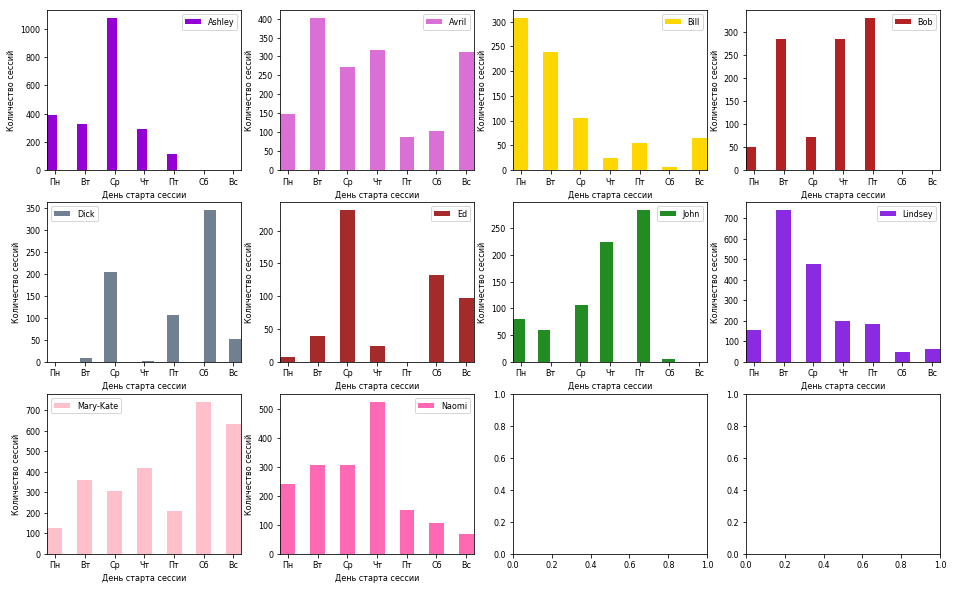

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx//ncols, idx%ncols].hist(sub_df['day_of_week'], bins=13, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlim([0,6]) 
    
    n_unique = len(sub_df['day_of_week'].unique())
    axes[idx//ncols, idx%ncols].set_xticks(np.linspace(0.25, 5.75, 7))
    axes[idx//ncols, idx%ncols].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx//ncols, idx%ncols].set_xlabel('День старта сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Эшли. Значительное кол-во сессий из одного сайта (по сравнению с распределением по всем 10 пользователям). Сравнительно много сессий в ранние утренние часы, потом кол-во сессий заметно падает, и есть характерный пик в обеденное время ~ 14 часов. Не выходит в интернет в выходные, зато в среду интернета очень много.
2. Аврил. Кол-во уникальных сайтов в сессии распределено нормально, среднее примерно равно 5, что чуть меньше, чем соответствующая мода распределения по всем пользователям. Распределение по времени старта сессии также близко к нормальному с небольшим провалом около 15 часов (обед?). Наблюдается провал в кол-ве сессий в пятницу и субботу (отдых от учёбы?).
3. Билл. Небольшой, но заметное на фоне остальных пользователей кол-во сессий из одго сайта. Большая часть сессий приходится на периоды ~ 9 и ~ 14-15 часов. Необычный график распредления сессий по дням недели -- с большим пиком в понедельник и вторник.
4. Боб. Кол-во уникальных сайтов в сессии распределено нормально, примерно как у Аврил. Большая часть посещений приходится на утренние часы ~9-10 и на 15 часов (обед?) -- распределение похоже на таковое для Эшли. На графике распределения сессий по дням провал на выходных (очень похоже на то, что мы видели у Эшли).
5. Дик. Очень много сессий из всего двух сайтов. Интернет используется достаточно равнменрно в течение дня, но есть провал около 19-20 часов и небольшие пики около 10 и 16 часов. При этом подавляющая часть сессий приходится на субботу и на вторник при почти полном отсутствии сессий в среду и четверг.
6. Эд. Соответствующее среднему распределение по кол-ву сайтов в сессии. Почти соответствующее среднему распределние по времени старта сессии (подобно тому, как у Аврил). Очень много сессий в среду и в выходные. 
7. Джон. распределние по кол-ву сайтов в сессии -- среднее. График использования -- тоже. При этом большинство сессий приходится на пятницу и субботу, что существенно отличает этого пользователя от предыдущего (у которого сессий в пятницу вообще нет). 
8. Линдси. Очень похожа на двоих предыдущих по первым двум параметрам (число уникальных сайтов в сессии и распределние сессий по времни в течение дня). Отличие в недельном графике : очень нмого сессий во вторник, чуть меньше -- в среду, и почти совсем нет в субботу.
9. Мэри-Кейт. Очень много сессий из двух сайтов. Нехарактерное распределение по времени старта сессии -- мало утренних сессий и больше вечерних. Почти равномерное распределение сессий по рабочей неделе, и очень много на выходных. Гипотезы здесь строить сложно, интеренет может использоваться как для учёбы, так и для развлечений. Однако маловероятно, чтобы этот пользователь вёл активную социальную жизнь.
10. Наоми. Распределения по всем трём признакам примерно совпадают со средними. На выходных и в пятницу интернет используется меньше, также мало используется в нерабочие часы. Можно предполагать активную социальную жизнь.

**Резюме**. Похоже, все три рассмотренных признака являются информативными, хотя скорее всего, первый (кол-во уникальных сайтовв сессии) информативен в меньшей степени (можно заменить его бинарным признаком доли сессий из 1-2 уникальных сайтов).  

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as file :
        try :
            while True:
                site_freq_10users = pickle.load(file)
        except EOFError :
            pass

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_sites = list(site_freq_10users)[:10]
top10_freqs = [site_freq_10users[site][1] for site in top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

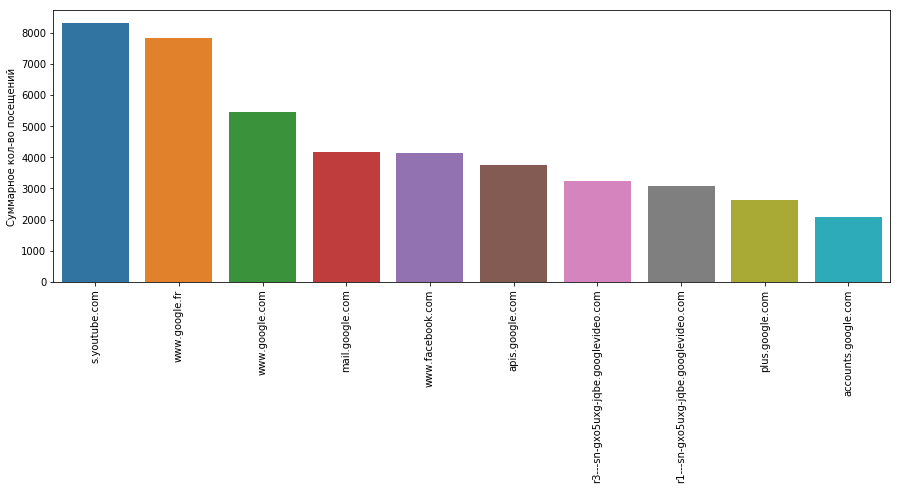

In [ ]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(15, 5))
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)
plt.ylabel('Суммарное кол-во посещений')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, top_30_sites, session_length=10, window_size=10):

    with open(site_freq_path, 'rb') as file :
        try :
            while True:
                site_dict = pickle.load(file)
        except EOFError :
            pass
            # print('Sites dictionary not loaded')

            
    files = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    n_users = len(files)

    sites_arr = np.zeros((int(np.ceil(n_users*20000/window_size)), len(feature_names)-1), dtype=int)
    top30_sum = np.zeros((int(np.ceil(n_users*20000/window_size)), 1), dtype=float)
    target = np.zeros((int(np.ceil(n_users*20000/window_size)), 1), dtype=float)

    i = 0
    for f in tqdm_notebook(range(n_users), desc='files_loaded : '):
        data = pd.read_csv(files[f])
        user_id = int(os.path.basename(files[f])[4:8])

        n_sites = data.shape[0]
        n_sess = n_sites // window_size + (n_sites % window_size > 0)
        n_samples = (n_sess-1) * window_size + session_length
        
        timestamp = pd.to_datetime(data.timestamp)
        
        indexer = np.arange(session_length)[None, :] + window_size * np.arange(n_sess)[:, None]
        
        sites_arr[i:i+n_sess, 0] = timestamp[::window_size].dt.year.values #start year
        sites_arr[i:i+n_sess, 1] = timestamp[::window_size].dt.month.values #start month
        sites_arr[i:i+n_sess, 2] = timestamp[::window_size].dt.day.values #start day                 
        
        sites_arr[i:i+n_sess, 3] = timestamp[::window_size].dt.hour.values % 4 #times_of_day
        
        np_arr = np.array([site_dict[key][0] for key in data.site.values] + \
                          (n_samples > n_sites) * (n_samples - n_sites) * [0])
        indexer = np.arange(session_length)[None, :] + window_size * np.arange(n_sess)[:, None]
                
        top30_sum[i:i+n_sess, 0] = (np_arr[indexer] < 31).mean(axis=1) # percent of top-30 sites in current session
        if np_arr[-1] == 0 :
            top30_sum[i+n_sess-1, 0] = (np_arr[indexer[-1,:]][np_arr[indexer[-1,:]]!=0] < 31).mean()
            
        for j, site in enumerate(top_30_sites) :
             sites_arr[i:i+n_sess, 4+j] = ((np_arr[indexer] == j+1).sum(axis=1) > 0).astype(int) # presence of top-30 sites in current session
        
        target[i:i+n_sess, 0] = user_id
        
        i += n_sess

    df = pd.DataFrame(data=sites_arr[:i, :], columns=feature_names[:-1]) 
    df[feature_names[-2]] = top30_sum[:i, 0]
    df[feature_names[-1]] = target[:i, 0]
    
    
    return df

In [ ]:
feature_names_extra = ['start_year', 'start_month', 'start_day', 'times_of_day'] + \
                      ['top' + str(i) for i in range(1,31)] + \
                      ['top30_percent', 'target']

In [ ]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as file :
        try :
            while True:
                site_freq_10users = pickle.load(file)
        except EOFError :
            pass
        
with open(os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'), 'rb') as file :
        try :
            while True:
                site_freq_150users = pickle.load(file)
        except EOFError :
            pass
        
top_30_sites_10users = list(site_freq_10users)[:30]
top_30_sites_150users = list(site_freq_150users)[:30]

In [ ]:
new_exta_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                                site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'),
                                                feature_names=feature_names_extra, 
                                                top_30_sites=top_30_sites_10users, 
                                                session_length=10)

In [ ]:
new_exta_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                                 site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'),
                                                 feature_names=feature_names_extra, 
                                                 top_30_sites=top_30_sites_150users, 
                                                 session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

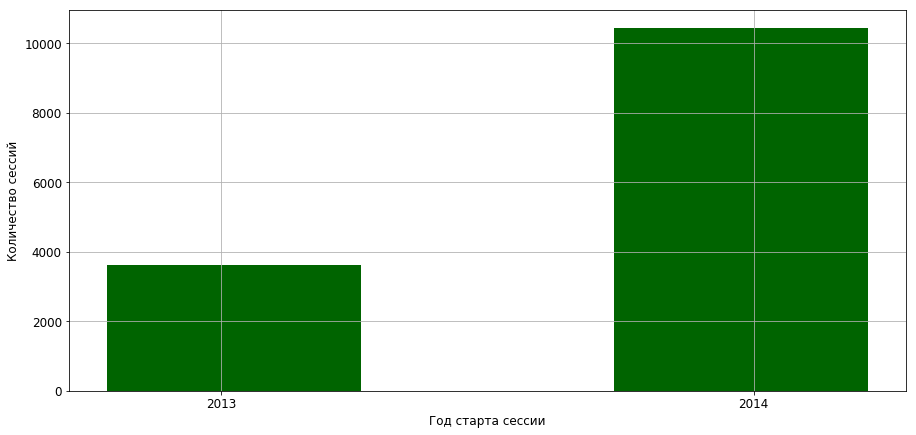

In [ ]:
new_exta_features_10users['target'] = new_exta_features_10users['target'].map(id_name_dict)


plt.rcParams.update({'font.size': 12})

new_exta_features_10users['start_year'].hist(bins=3, figsize=(15,7), color='darkgreen')

plt.xticks([2013.15, 2013.85], ['2013', '2014'])
plt.xlabel('Год старта сессии')
plt.ylabel('Количество сессий')
plt.show()

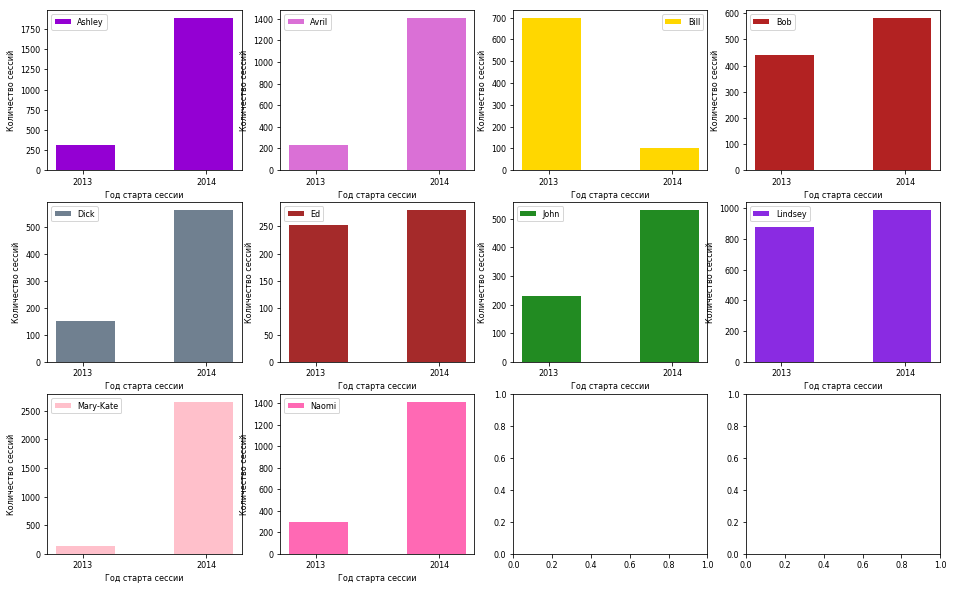

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(new_exta_features_10users, 'target')):
    axes[idx//ncols, idx%ncols].hist(sub_df['start_year'], bins=3, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xticks([2013.15, 2013.85])
    axes[idx//ncols, idx%ncols].set_xticklabels(['2013', '2014'])
    axes[idx//ncols, idx%ncols].set_xlabel('Год старта сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

- несмотря на то, что у признака всего два уникальных значения, пользователи сильно различаются по распредлению его значений, таким образом, признак можно исопльзовать для идентификации пользователей в данном конкретном датасете

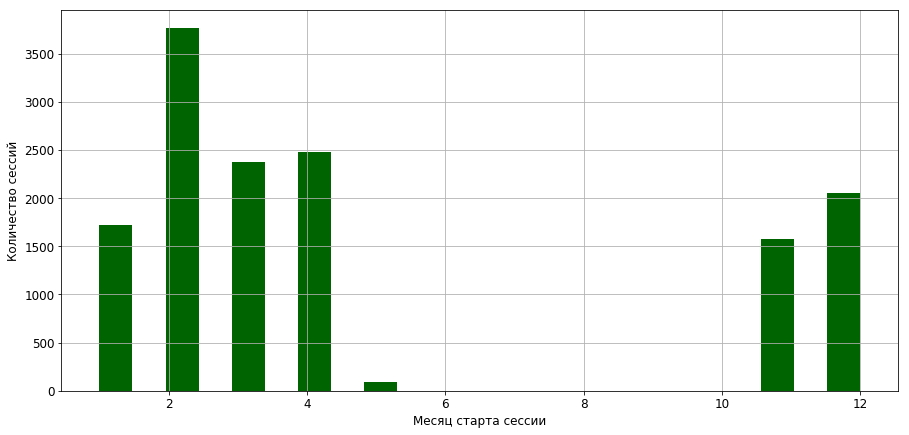

In [ ]:
plt.rcParams.update({'font.size': 12})

new_exta_features_10users['start_month'].hist(bins=23, figsize=(15,7), color='darkgreen')

plt.xlabel('Месяц старта сессии')
plt.ylabel('Количество сессий')
plt.show()

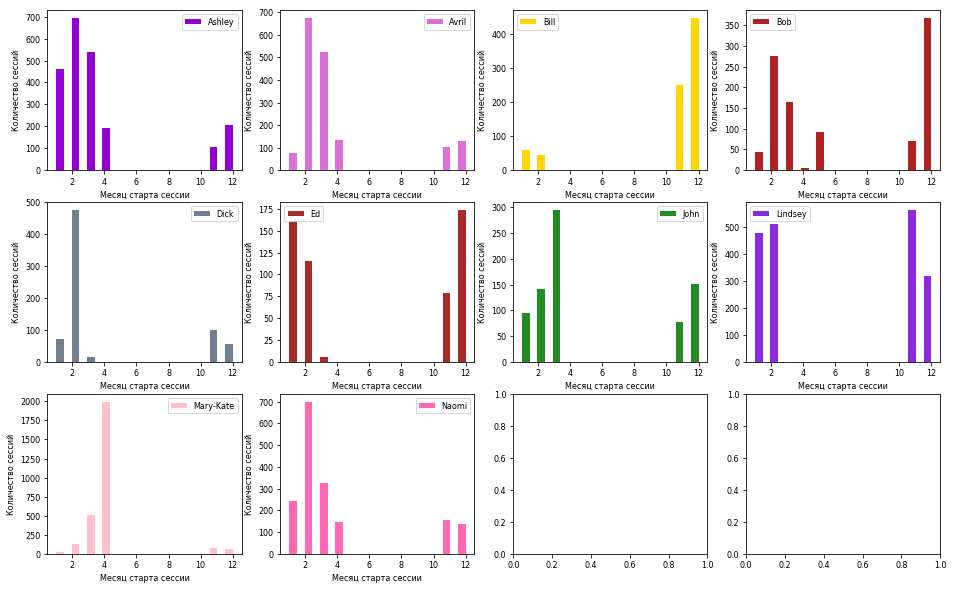

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(new_exta_features_10users, 'target')):
    axes[idx//ncols, idx%ncols].hist(sub_df['start_month'], bins=23, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlabel('Месяц старта сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

- пользователи сильно различаются по распредлению значений признака, таким образом, признак точно стоит исопльзовать для идентификации пользователей

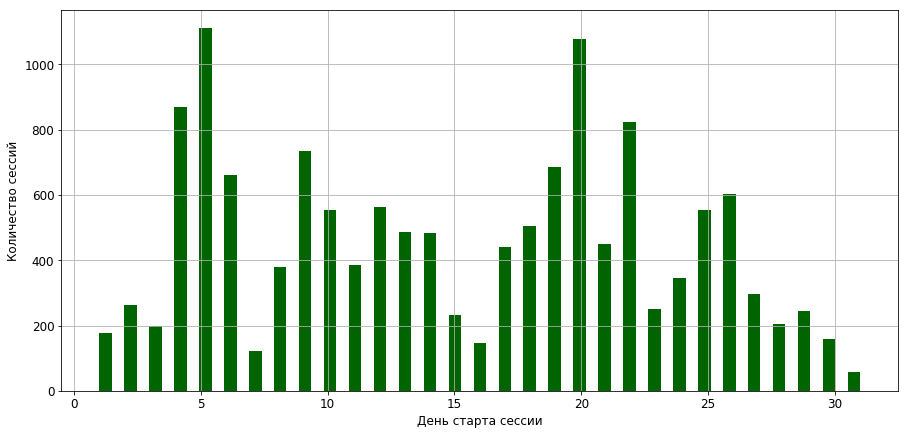

In [ ]:
plt.rcParams.update({'font.size': 12})

new_exta_features_10users['start_day'].hist(bins=61, figsize=(15,7), color='darkgreen')

plt.xlabel('День старта сессии')
plt.ylabel('Количество сессий')
plt.show()

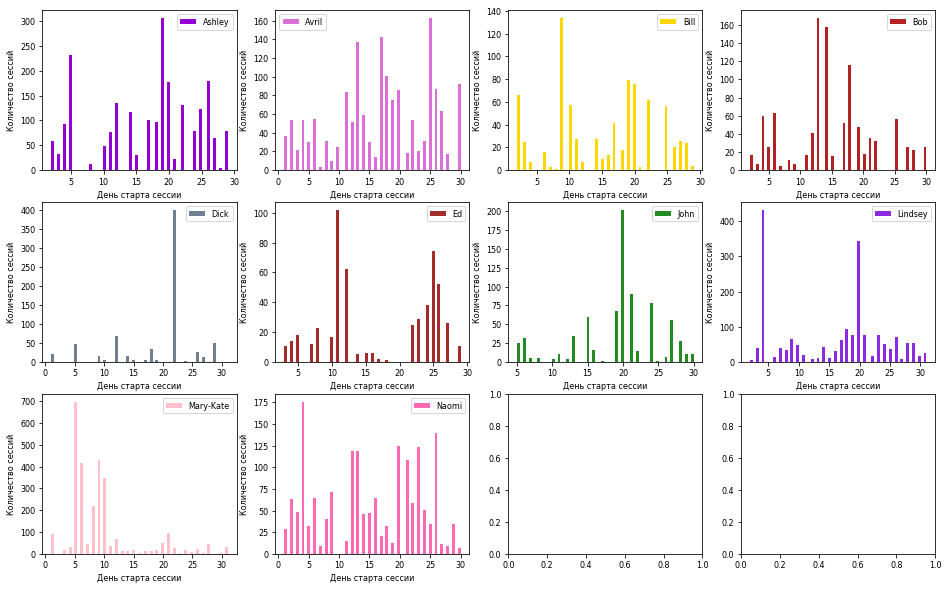

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(new_exta_features_10users, 'target')):
    axes[idx//ncols, idx%ncols].hist(sub_df['start_day'], bins=61, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlabel('День старта сессии') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

- достаточно неожиданно, но по дню старта сессии пользовательские данные распределены также распределены очень неравномерно, поэтому признак можно использовать

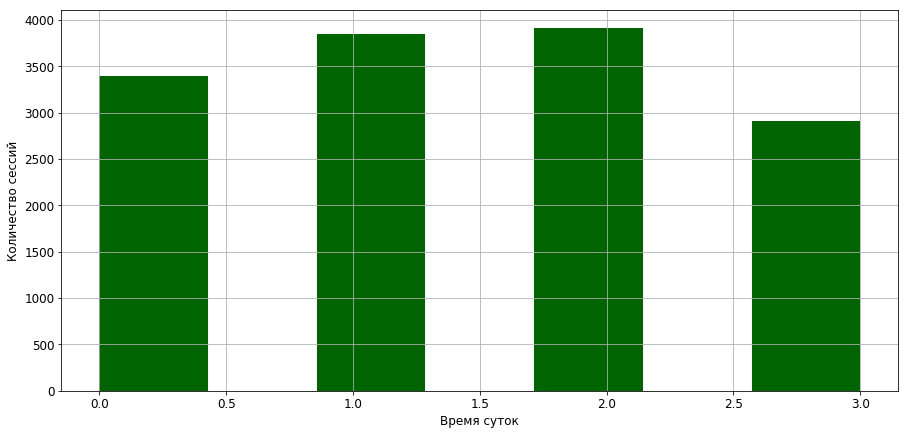

In [ ]:
plt.rcParams.update({'font.size': 12})

new_exta_features_10users['times_of_day'].hist(bins=7, figsize=(15,7), color='darkgreen')

plt.xlabel('Время суток') # ночь - утро - день -вечер
plt.ylabel('Количество сессий')
plt.show()

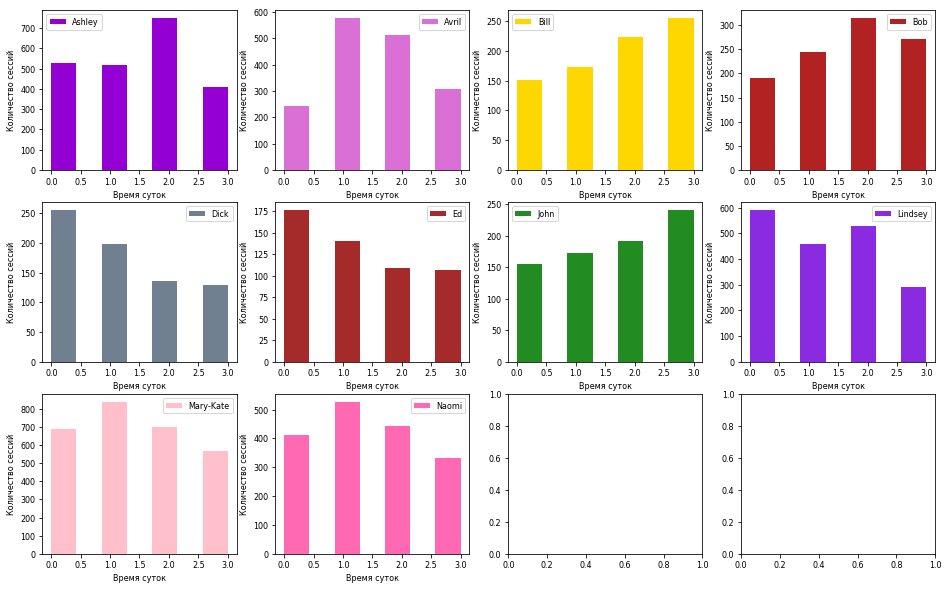

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

ncols=4
for idx, (user, sub_df) in  enumerate(pd.groupby(new_exta_features_10users, 'target')):
    axes[idx//ncols, idx%ncols].hist(sub_df['times_of_day'], bins=7, color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlabel('Время суток') 
    axes[idx//ncols, idx%ncols].set_ylabel('Количество сессий')

- здесь распределения не настолько сильно отичаются между пользователями (хотя и заметно), и эти различия уже учтены в признаке часа старта сессии, поэтому, по всей видимости, этот признак не стоит добавлять в итоговый датасет

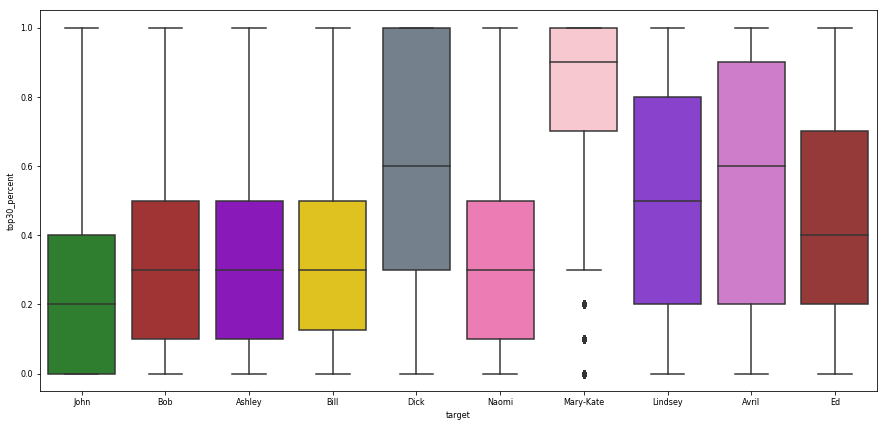

In [ ]:
fig = plt.figure(figsize=(15,7))
sns.boxplot(x=new_exta_features_10users.target, 
            y=new_exta_features_10users.top30_percent, 
            palette=[color_dic[k] for k in new_exta_features_10users.target.unique()])
plt.show()

- признак "процент сайтов из топ-30 в сессии" достаточно информативен, распределния значений у разных пользователей заметно различаются, поэтому признак стоит оставить в датасете; далее можно также поэкспериментировать с процентом сайтов из топ-10 или процентом сайтов из топ-20

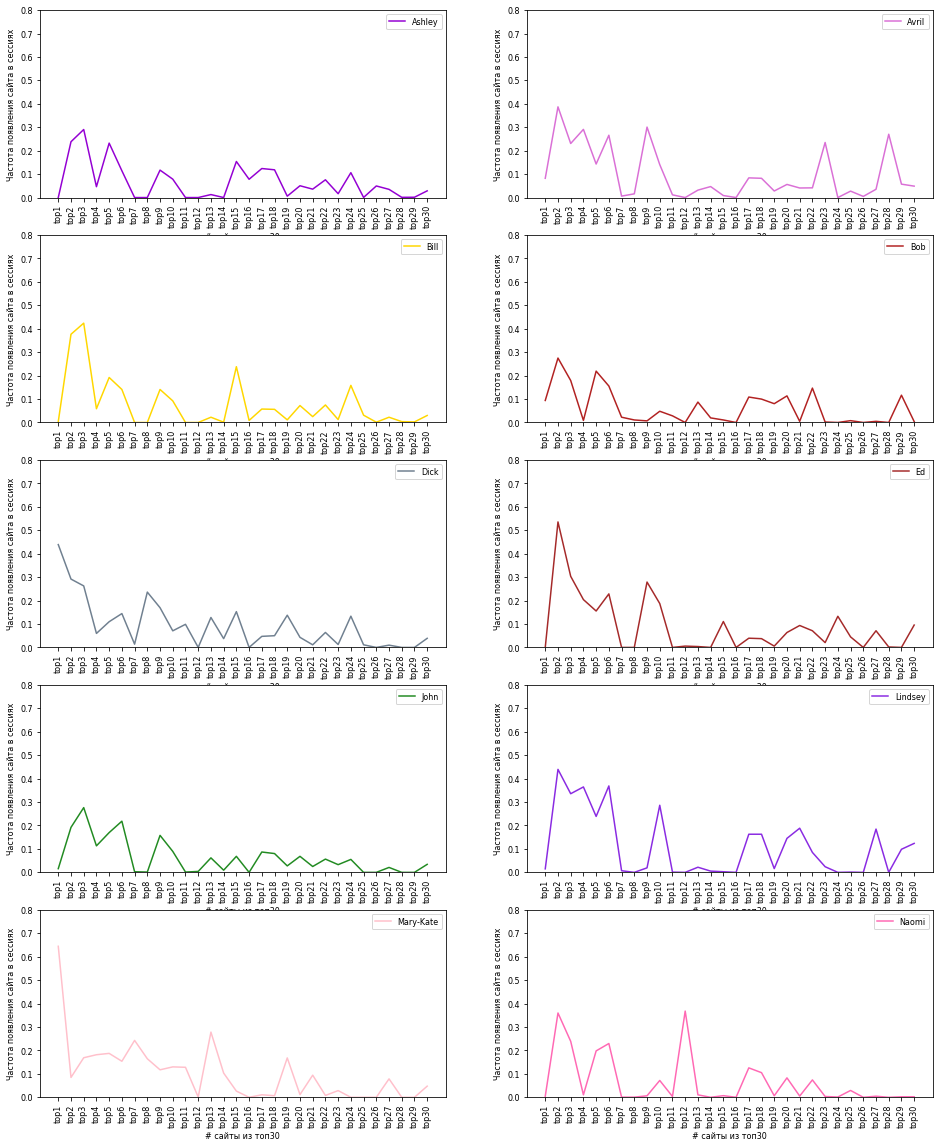

In [ ]:
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))

ncols=2
for idx, (user, sub_df) in  enumerate(pd.groupby(new_exta_features_10users, 'target')):
    axes[idx//ncols, idx%ncols].plot(sub_df[['top' + str(i) for i in range(1,31)]].mean(axis=0), color=color_dic[user], label=user)
    axes[idx//ncols, idx%ncols].legend()
    axes[idx//ncols, idx%ncols].set_xlabel('# cайты из топ30')
    axes[idx//ncols, idx%ncols].set_xticklabels(['top' + str(i) for i in range(1,31)], rotation = 90)
    axes[idx//ncols, idx%ncols].set_ylabel('Частота появления сайта в сессиях')
    axes[idx//ncols, idx%ncols].set_ylim([.0, .8])

- есть заметные разлия между пользователями по частоте посещения сайтов из топ-30, поэтому бинарные признаки наличия этих сайтов в сессии могут также быть полезны при решении задачи идентификации пользователей

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = pd.concat((train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']], 
                                       new_exta_features_10users[['start_year', 'start_month', 'start_day', 'top30_percent'] + \
                                                                 ['top' + str(i) for i in range(1,31)]]), axis=1)
selected_features_150users = pd.concat((train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']],
                                        new_exta_features_150users[['start_year', 'start_month', 'start_day', 'top30_percent'] + \
                                                                   ['top' + str(i) for i in range(1,31)]]), axis=1)

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 